## Projeto 2

###### Aluno: Vitor Mazal Krauss

###### Considerações iniciais:

Implementamos os métodos de integração Runge Kutta 4 e Verlet para o 'N-body model' do Sistema Solar, levando em consideração a gravitação entre os corpos. A implementação numérica deste projeto é toda feita em C++, por conta de sua melhor performance, e o seu código está disponível junto dos outros arquivos do projeto.

Os dados gerados pela simulação no C++ foram salvos em formato csv e vamos importá-los como Pandas DataFrames.

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import Video
import scipy.stats

In [2]:
NUM_KNOWN_BODIES = 9
NUM_ASTEROIDS = 250
NUM_OF_BODIES = NUM_KNOWN_BODIES + NUM_ASTEROIDS
NUM_OF_STEPS = 10**6
TIME_STEP = 5.4*10**3

### Parte 1: Verlet

Nesta parte implementamos o método de Verlet para integração. Fazemos uma simulação dos 8 planetas do Sistema Solar, além do Sol. Consideramos um tamanho de passo $dt = 5.4*10^3$ segundos para $10^6$ passos. Ou seja, nossa simulação cobre $5.4*10^9$ segundos, aproximadamente $170$ anos, um pouco a mais que o tempo para Netuno, o planeta mais distante do Sol, completar uma órbita em torno do Sol.

Como mencionado, a implementação da simulação é feita em C++. O primeiro passo é importar os dados gerados na simulação.

In [3]:
method = 'verlet'
date = '5_10_'
dir_path = os.path.join('C:\\', 'Users', 'vmk10', 'Documents', 'UFRJ', 'Notebooks_2019.2', 'Computação Científica 2', 'Projeto_2', date + method)
verlet_positions = [None]*NUM_KNOWN_BODIES
verlet_energies = [None]*NUM_KNOWN_BODIES
verlet_angular = [None]*NUM_KNOWN_BODIES
for i in range(NUM_KNOWN_BODIES):
    file_name = date + method + '_body_' + str(i) + '.txt'
    path = os.path.join(dir_path, file_name)
    verlet_positions[i] = pd.read_csv(path, sep=', ', header=None, dtype=float) #engine='python'
    if(i < NUM_KNOWN_BODIES):
        file_name = date + method + '_kinetic_energy_' + str(i) + '.txt'
        path = os.path.join(dir_path, file_name)
        verlet_energies[i] = pd.DataFrame(pd.read_csv(path, header=None), dtype=float)
        file_name = date + method + '_angular_momentum_' + str(i) + '.txt'
        path = os.path.join(dir_path, file_name)
        verlet_angular[i] = pd.DataFrame(pd.read_csv(path, header=None), dtype=float)

C:\Users\vmk10\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  # Remove the CWD from sys.path while we load stuff.


Podemos ver abaixo os detalhes da simulação:

In [4]:
stats_file = os.path.join(dir_path, date + method + '_time.txt')
stats = open(stats_file).read()
print(stats)

Method: verlet 
Baking time = 1599.94 seconds 
with timestep = 5400 seconds 
for 1000000 steps 
with 9 bodies 



Como primeiro passo na análise da nossa simulação, podemos plotar as posições geradas ao longo de toda a simulação.

C:\Users\vmk10\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


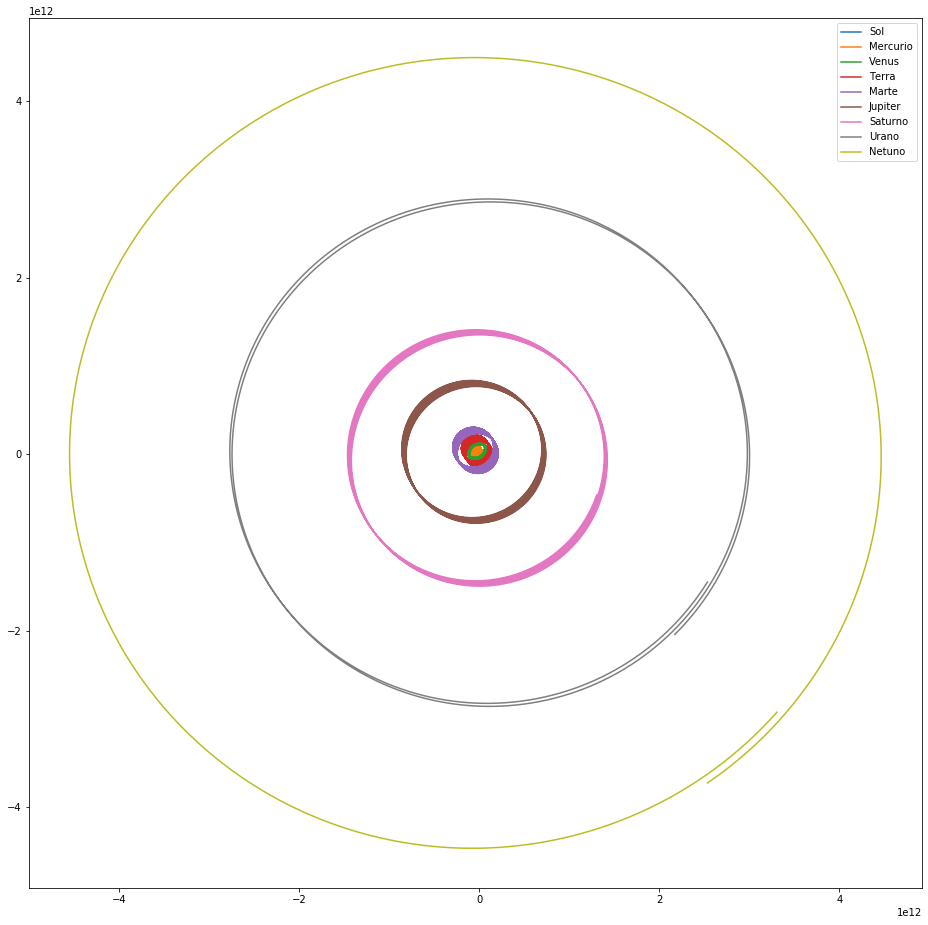

In [5]:
fig, ax = plt.subplots(1,1, figsize=(16, 16))
body_names = ['Sol', 'Mercurio', 'Venus', 'Terra', 'Marte', 'Jupiter', 'Saturno', 'Urano', 'Netuno']
for i in range(NUM_KNOWN_BODIES):
    ax.plot(verlet_positions[i][0], verlet_positions[i][1], label=body_names[i])
ax.legend()
plt.show()

Podemos também fazer uma animação.

In [6]:
verlet_frames = [None]*NUM_OF_STEPS
for i in range(NUM_OF_STEPS):
    x = np.zeros(NUM_KNOWN_BODIES)
    y = np.zeros(NUM_KNOWN_BODIES)
    z = np.zeros(NUM_KNOWN_BODIES)
    for j in range(NUM_KNOWN_BODIES):
        x[j] = verlet_positions[j].iloc[i, 0]
        y[j] = verlet_positions[j].iloc[i, 1]
        z[j] = verlet_positions[j].iloc[i, 2]
    verlet_frames[i] = [x, y, z]

In [7]:
vxmax1 = max([max(np.absolute(verlet_frames[i][0][0:5])) for i in range(NUM_OF_STEPS)])
vymax1 = max([max(np.absolute(verlet_frames[i][1][0:5])) for i in range(NUM_OF_STEPS)])
vzmax1 = max([max(np.absolute(verlet_frames[i][2][0:5])) for i in range(NUM_OF_STEPS)])
vxmax2 = max([max(np.absolute(verlet_frames[i][0])) for i in range(NUM_OF_STEPS)])
vymax2 = max([max(np.absolute(verlet_frames[i][1])) for i in range(NUM_OF_STEPS)])
vzmax2 = max([max(np.absolute(verlet_frames[i][2])) for i in range(NUM_OF_STEPS)])

In [8]:
plt.rcParams['animation.ffmpeg_path'] ='C:\\ffmpeg\\bin\\ffmpeg.exe'
def anima(name, N_FRAMES, frames, xlim_, ylim_, xlim, ylim, names, scale, title): 
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle(title)
    ax[0].set_xlim(-1*xlim_, xlim_)
    ax[0].set_ylim(-1*ylim_, ylim_)
    ax[1].set_xlim(-1*xlim, xlim)
    ax[1].set_ylim(-1*ylim, ylim)
    def init():
        ax[0].plot(frames[0][0][0:5], frames[0][1][0:5], 'o')
        ax[1].plot(frames[0][0][5:9], frames[0][1][5:9], 'o')
        return ax[0], ax[1]
    def iterate(i):
        k = scale*i
        ax[0].clear()
        ax[1].clear()
        ax[0].set_xlim(-1*xlim_, xlim_)
        ax[0].set_ylim(-1*ylim_, ylim_)
        ax[1].set_xlim(-1*xlim, xlim)
        ax[1].set_ylim(-1*ylim, ylim)
        ax[0].plot(frames[i][0][1:5], frames[i][1][1:5], 'o')
        ax[1].plot(frames[k][0][5:9], frames[k][1][5:9], 'o')
        ax[0].plot(frames[i][0][0], frames[i][1][0], '*', markersize=13)
        ax[1].plot(frames[k][0][0], frames[k][1][0], '*', markersize=13)
        for j in range(5):
            ax[0].annotate(names[j], (frames[i][0][j], frames[i][1][j]))
        for j in range(5, 9):
            ax[1].annotate(names[j], (frames[k][0][j], frames[k][1][j]))
        ax[1].annotate(names[0], (frames[k][0][0], frames[k][1][0]))
        ax[0].set_title("The first four, at step = %d" %(i))
        ax[1].set_title("The last four, at step = %d" %(k))
        return ax[0], ax[1]
    ani = animation.FuncAnimation(fig, iterate, N_FRAMES, init_func=init, interval=10)
    FFwriter = animation.FFMpegWriter(fps=120, extra_args=['-vcodec', 'libx264'])
    ani.save(name+'.mp4', writer=FFwriter)

As distâncias dos quatro primeiros planetas, Mércurio, Vênus, Terra e Marte, ao Sol são, relativamente, muito menores que as distancias dos últimos quatro planetas, Jupiter, Saturno, Urano e Netuno. Plotar todos os oito planetas no mesmo gráfico dificulta a visualização por conta desse problema de escala. Por isso plotamos estes dois conjuntos de planetas em gráficos separados. Além disso, o período orbital dos últimos quatro planetas é muito maior. Por isso, para estes planetas, escalamos a velocidade da animação, isto é, não iteramos de frame em frame, mas iteramos a cada $k$ frames. Neste caso, tomamos $k=50$.

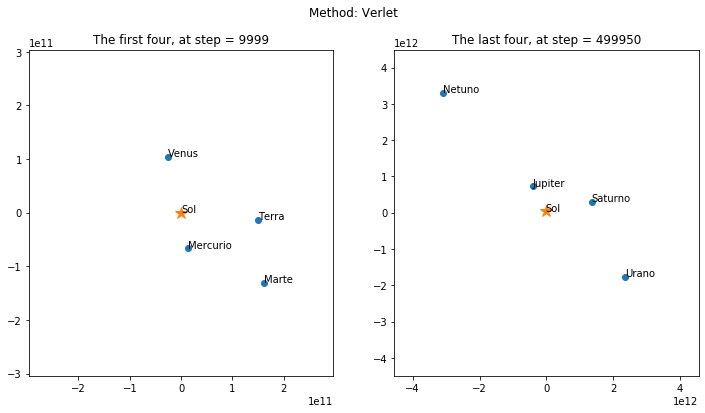

In [9]:
anima('verlet_video', 10000, verlet_frames, vxmax1, vymax1, vxmax2, vymax2, body_names, 50, 'Method: Verlet')

In [10]:
Video('verlet_video.mp4')

### Parte 2: Runge-Kutta 4

Nesta parte utilizamos o método de Runge-Kutta 4 para a integração. Simulamos o mesmo cenário que na Parte 1, ou seja, simulamos os oito planetas do Sistema Solar, além do Sol, tomando tamanho de passo $dt = 5.4*10^3$ segundos e simulando $10^6$ passos. Novamente, a implementação do método é feita em C++ e nos importamos os dados.

In [12]:
method = 'runge_kutta'
date = '5_10_'
dir_path = os.path.join('C:\\', 'Users', 'vmk10', 'Documents', 'UFRJ', 'Notebooks_2019.2', 'Computação Científica 2', 'Projeto_2', date + method)
rk_positions = [None]*NUM_OF_BODIES
rk_energies = [None]*NUM_KNOWN_BODIES
rk_angular = [None]*NUM_KNOWN_BODIES
for i in range(NUM_KNOWN_BODIES):
    file_name = date + method + '_body_' + str(i) + '.txt'
    path = os.path.join(dir_path, file_name)
    rk_positions[i] = pd.read_csv(path, sep=', ', header=None, dtype=float)
    if(i < NUM_KNOWN_BODIES):
        file_name = date + method + '_kinetic_energy_' + str(i) + '.txt'
        path = os.path.join(dir_path, file_name)
        rk_energies[i] = pd.DataFrame(pd.read_csv(path, header=None), dtype=float)
        file_name = date + method + '_angular_momentum_' + str(i) + '.txt'
        path = os.path.join(dir_path, file_name)
        rk_angular[i] = pd.DataFrame(pd.read_csv(path, header=None), dtype=float)

C:\Users\vmk10\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  # Remove the CWD from sys.path while we load stuff.


Abaixo os detalhes da simulação.

In [13]:
stats_file = os.path.join(dir_path, date + method + '_time.txt')
stats = open(stats_file).read()
print(stats)

Method: runge_kutta 
Baking time = 4224.17 seconds 
with timestep = 5400 seconds 
for 1000000 steps 
with 9 bodies 



A primeira observação a ser feita é quanto a diferença do tempo de execução dos dois métodos. Observe que para a simulação de um mesmo cenário, o método de Runge-Kutta levou aproximadamente $2.5$ vezes mais tempo.

Novamente, começamos com um gráfico das posições de todos os planetas gerados ao longo de toda a simulação.

C:\Users\vmk10\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


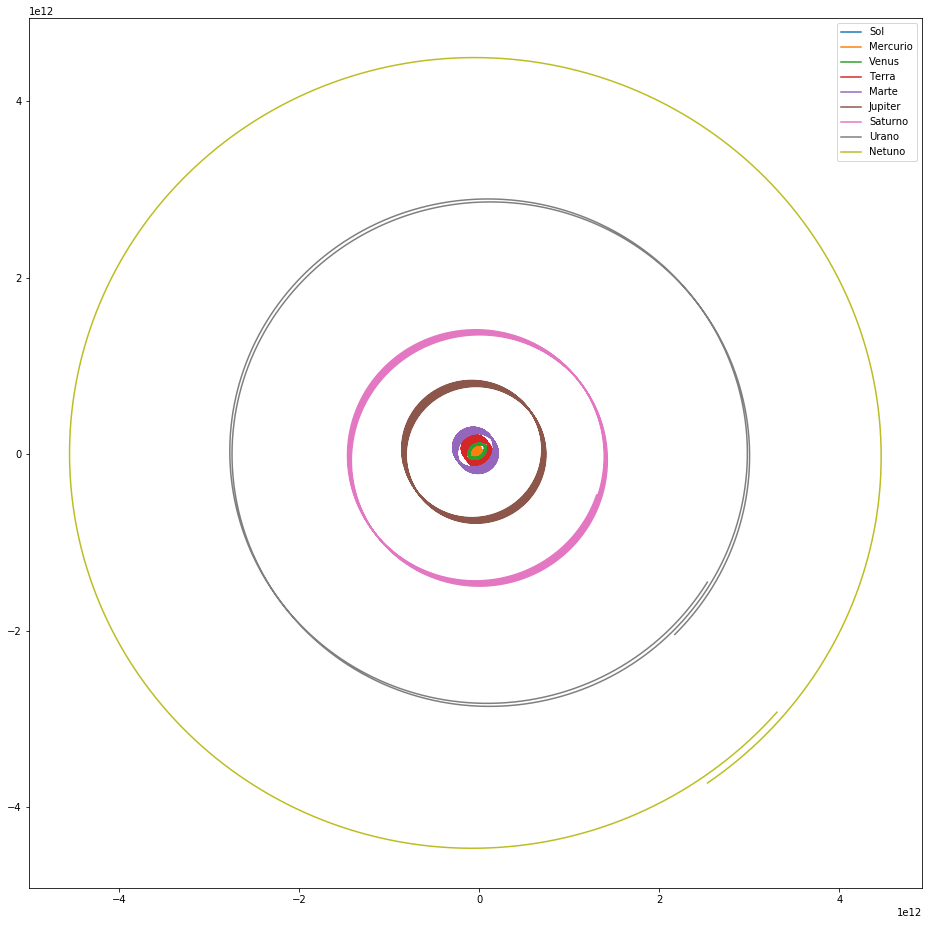

In [14]:
fig, ax = plt.subplots(1,1, figsize=(16, 16))
for i in range(NUM_KNOWN_BODIES):
    ax.plot(rk_positions[i][0], rk_positions[i][1], label=body_names[i])
ax.legend()
plt.show()

In [15]:
rk_frames = [None]*NUM_OF_STEPS
for i in range(NUM_OF_STEPS):
    x = np.zeros(NUM_KNOWN_BODIES)
    y = np.zeros(NUM_KNOWN_BODIES)
    z = np.zeros(NUM_KNOWN_BODIES)
    for j in range(NUM_KNOWN_BODIES):
        x[j] = rk_positions[j].iloc[i, 0]
        y[j] = rk_positions[j].iloc[i, 1]
        z[j] = rk_positions[j].iloc[i, 2]
    rk_frames[i] = [x, y, z]

In [16]:
rkxmax1 = max([max(np.absolute(rk_frames[i][0][0:5])) for i in range(NUM_OF_STEPS)])
rkymax1 = max([max(np.absolute(rk_frames[i][1][0:5])) for i in range(NUM_OF_STEPS)])
rkzmax1 = max([max(np.absolute(rk_frames[i][2][0:5])) for i in range(NUM_OF_STEPS)])
rkxmax2 = max([max(np.absolute(rk_frames[i][0])) for i in range(NUM_OF_STEPS)])
rkymax2 = max([max(np.absolute(rk_frames[i][1])) for i in range(NUM_OF_STEPS)])
rkzmax2 = max([max(np.absolute(rk_frames[i][2])) for i in range(NUM_OF_STEPS)])

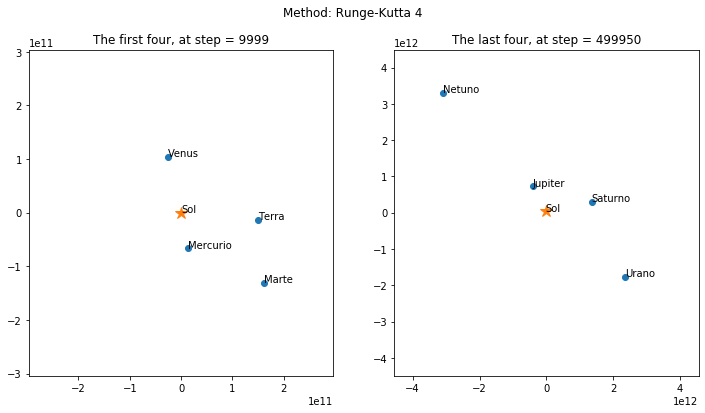

In [17]:
anima('rk_video', 10000, rk_frames, rkxmax1, rkymax1, rkxmax2, rkymax2, body_names, 50, 'Method: Runge-Kutta 4')

In [18]:
Video('rk_video.mp4')

### Parte 3: comparando os métodos

A questão fundamental aqui é a conservação de energia nos dois métodos implementados. O método de Verlet é um integrador simplético, enquanto o Runge-Kutta 4 não é. Integradores simpléticos são focados especialmente em sistemas hamiltonianos e supostamente, para tamanhos de passo adequados, conservam a energia do sistema. Assim, o objetivo desta parte é estudar o comportamento da energia total e do momento angular de cada corpo ao longo da simulação para os diferentes métodos. 

Estes valores de energia e momento foram calculados e armazenados a cada passo da simulação e já foram importados para este notebook.

Vamos considerar a energia total e o momento angular no instante inicial como o valor correto para cada corpo. Daí, para cada iteração da simulação, consideramos a diferença entre os valores da energia total e momento angular naquela momento com os valores iniciais. Dividimos esta diferença pelo valor inicial para obtermos a diferença percentual(ou erro percentual) na energia e no momento.

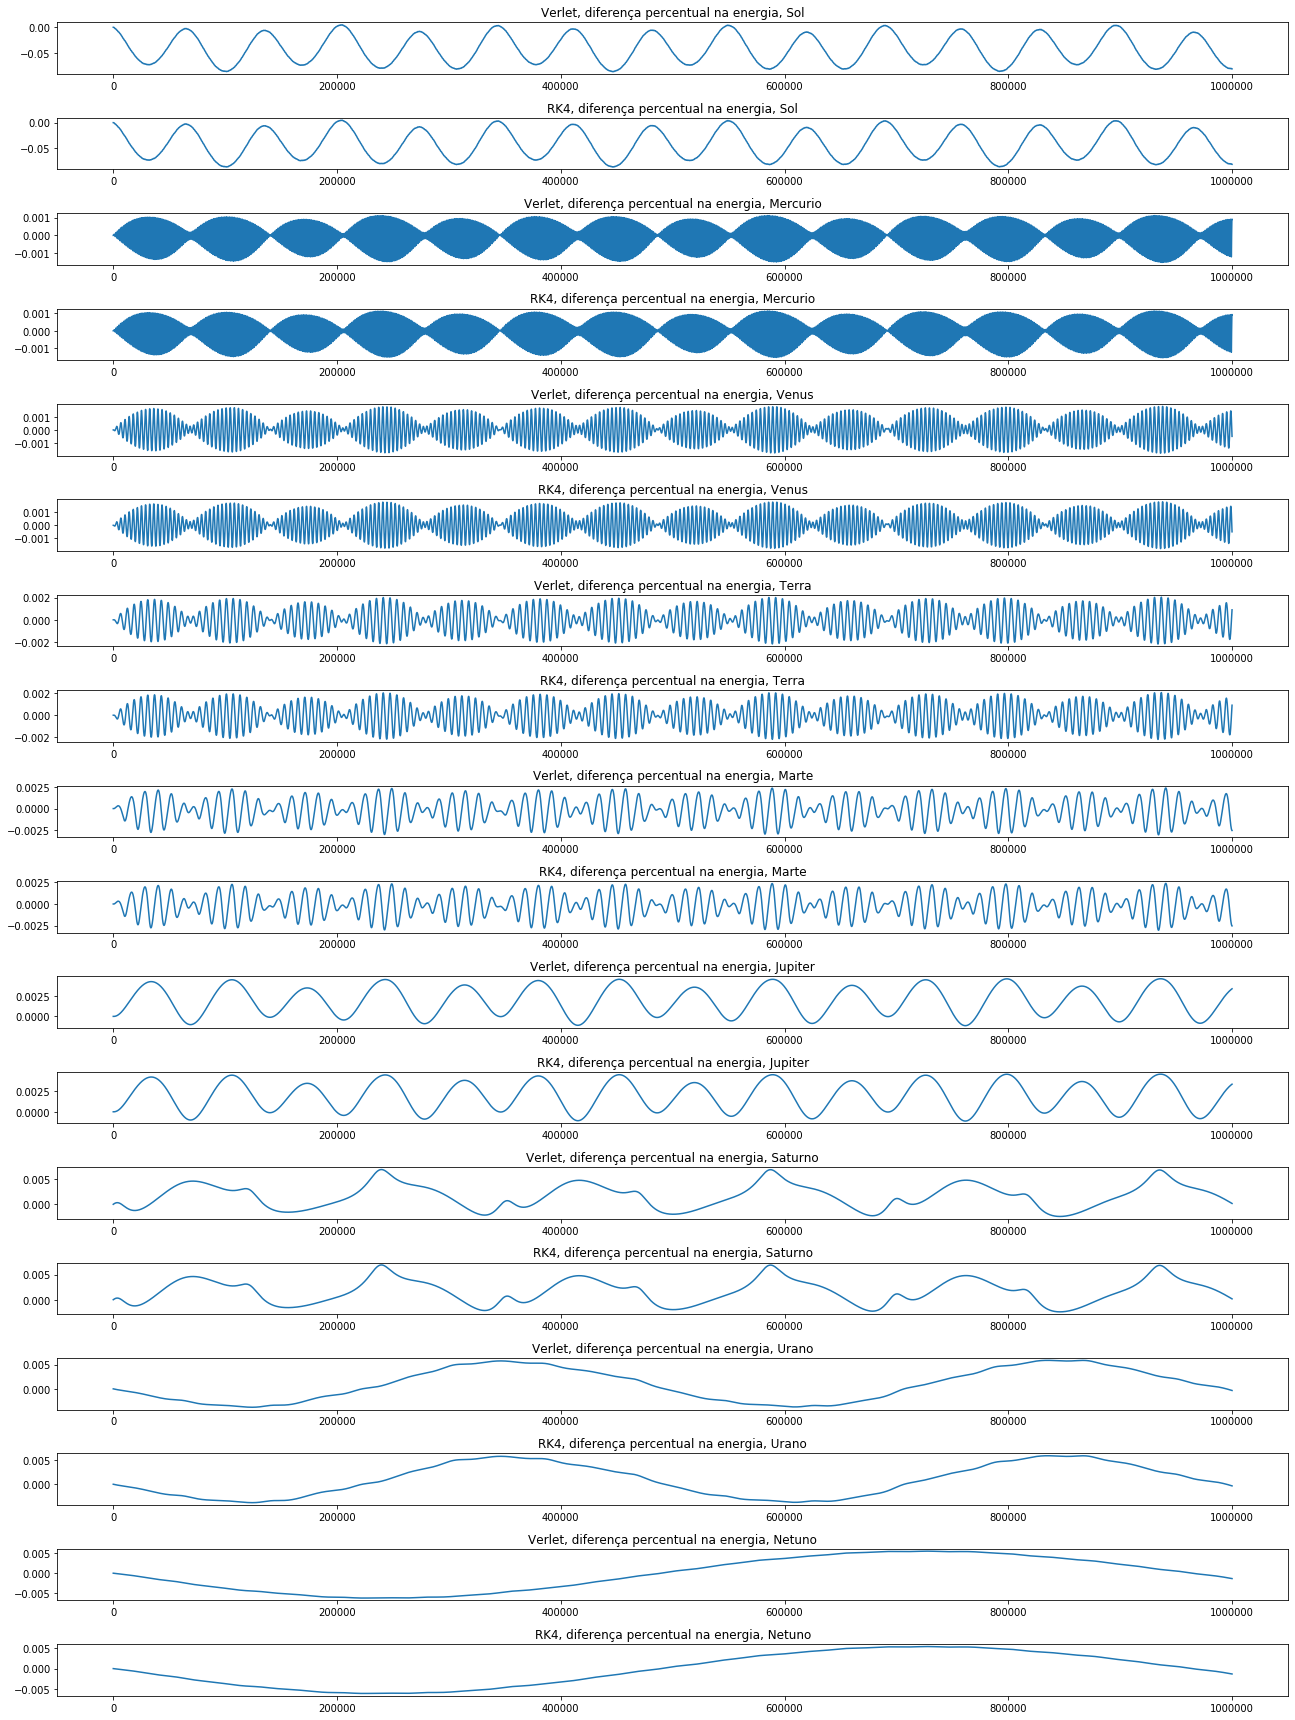

In [19]:
fig, ax = plt.subplots(2*NUM_KNOWN_BODIES, 1, figsize=(18, 24))
for i in range(NUM_KNOWN_BODIES):
    ax[2*i].plot((verlet_energies[i].iloc[:, 0] - verlet_energies[i].iloc[0, 0])/verlet_energies[i].iloc[0, 0])
    ax[2*i].set_title("Verlet, diferença percentual na energia, %s" %(body_names[i]))
    ax[2*i+1].plot((rk_energies[i].iloc[:, 0] - rk_energies[i].iloc[0, 0])/rk_energies[i].iloc[0, 0])
    ax[2*i+1].set_title("RK4, diferença percentual na energia, %s" %(body_names[i]))
plt.tight_layout()

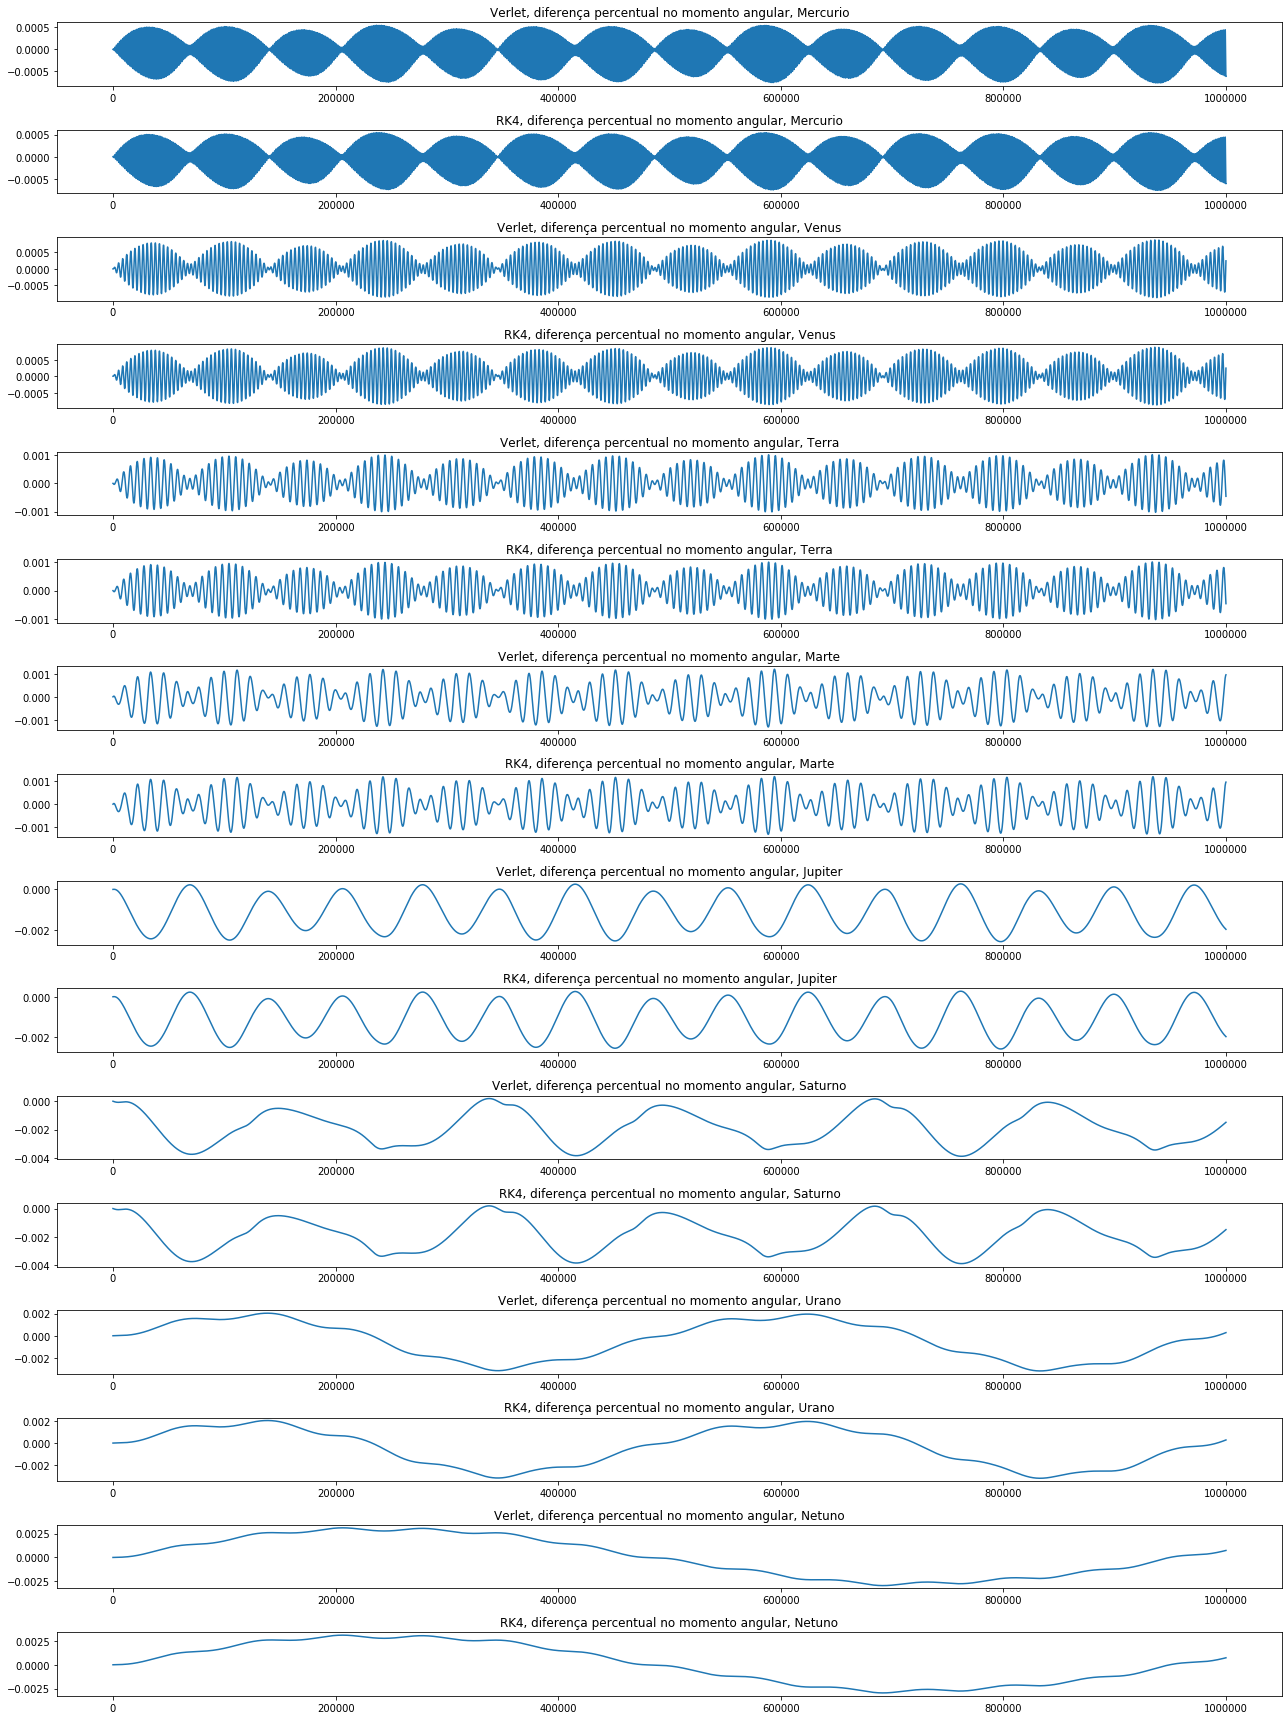

In [36]:
fig, ax = plt.subplots(2*(NUM_KNOWN_BODIES-1), 1, figsize=(18, 24))
for i in range(1,NUM_KNOWN_BODIES):
    j = i-1
    ax[2*j].plot((verlet_angular[i].iloc[:, 0] - verlet_angular[i].iloc[0, 0])/verlet_angular[i].iloc[0, 0])
    ax[2*j].set_title("Verlet, diferença percentual no momento angular, %s" %(body_names[i]))
    ax[2*j+1].plot((rk_angular[i].iloc[:, 0] - rk_angular[i].iloc[0, 0])/rk_angular[i].iloc[0, 0])
    ax[2*j+1].set_title("RK4, diferença percentual no momento angular, %s" %(body_names[i]))
plt.tight_layout()

Podemos ver que tanto Verlet quanto RK4 conservaram a energia ao longo da simulação. De fato, quase não houve diferença entre os métodos. Com efeito, o tamanho de passo $dt = 5.4*10^3$ é muito pequeno. A fim de explorar mais o comportamento destes métodos, vamos fazer várias simulações com mesmo número de iterações, porém vamos aumentar o tamanho de passo $dt$ em cada uma. 

In [21]:
direc = os.path.join('C:\\', 'Users', 'vmk10', 'Documents', 'UFRJ', 'Notebooks_2019.2', 'Computação Científica 2', 'Projeto_2')
verlet_earth_energies = [None]*12
rk_earth_energies = [None]*12
for k in range(12):
    file_name = 'num_' + str(k) + '_verlet_kinetic_energy_8.txt'
    path = os.path.join(direc, file_name)
    verlet_earth_energies[k] = pd.DataFrame(pd.read_csv(path, header=None), dtype=float)
    file_name = 'num_' + str(k) + '_runge_kutta_kinetic_energy_8.txt'
    path = os.path.join(direc, file_name)
    rk_earth_energies[k] = pd.DataFrame(pd.read_csv(path, header=None), dtype=float)

In [22]:
verlet_means = [None]*8
rk_means = [None]*8
for i in range(8):
    verlet_means[i] = ((abs(verlet_earth_energies[i].iloc[:, 0] - verlet_earth_energies[i].iloc[0,0])/abs(verlet_earth_energies[i].iloc[0,0]))).mean()
    rk_means[i] = ((abs(rk_earth_energies[i].iloc[:, 0] - rk_earth_energies[i].iloc[0,0])/abs(rk_earth_energies[i].iloc[0,0]))).mean()

Agora, para cada uma das simulações feitas(cada simulação tem tamanho de passo diferente), calculamos em cada iteração a diferença absoluta entre o valor inicial da energia e o valor naquela iteração, e dividimos pelo valor inicial absoluto. Isto nos dá as diferenças percentuais absolutas. Daí, para cada simulação, pegamos a média destas diferenças percentuais absolutas, que vamos chamar de MDP.

In [23]:
for i in range(8):
    print("Verlet, dt=%1.0f, MDP = %f" %( 10**(2+i), verlet_means[i],))
    print("RK4, dt=%1.0f, MDP = %f" %( 10**(2+i), rk_means[i],))

Verlet, dt=100, MDP = 0.000003
RK4, dt=100, MDP = 0.000003
Verlet, dt=1000, MDP = 0.000033
RK4, dt=1000, MDP = 0.000033
Verlet, dt=10000, MDP = 0.000309
RK4, dt=10000, MDP = 0.000309
Verlet, dt=100000, MDP = 0.003242
RK4, dt=100000, MDP = 0.003242
Verlet, dt=1000000, MDP = 0.003802
RK4, dt=1000000, MDP = 0.003848
Verlet, dt=10000000, MDP = 0.003745
RK4, dt=10000000, MDP = 0.003687
Verlet, dt=100000000, MDP = 0.003693
RK4, dt=100000000, MDP = 0.006263
Verlet, dt=1000000000, MDP = 3.244536
RK4, dt=1000000000, MDP = 43.612638


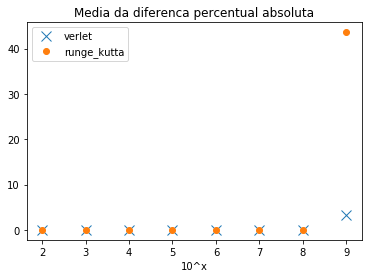

In [24]:
plt.plot(range(2, 10), verlet_means, 'x', markersize=10, label='verlet')
plt.plot(range(2, 10), rk_means, 'o', label='runge_kutta')
plt.title("Media da diferenca percentual absoluta")
plt.xlabel("10^x")
plt.legend()
plt.show()

Aqui fica clara a diferença entre o método de Verlet, que é simplético, e do Runge-Kutta, que não é simplético.
Podemos ver que para tamanhos de passo pequenos tanto o método de Verlet quanto o de Runge-Kutta 4 são muito eficientes em conservar a energia total do sistema. Observe, contudo, que, conforme o tamanho de passo cresce, o método de Runge-Kutta passa a demonstrar maior variação na energia total ao longo da simulação, ou seja, deixa de conservar a energia do sistema. Por outro lado, o método de Verlet continua demonstrando pouca variação na energia ao longo de toda a simulação mesmo com aumento do tamanho de passo, o que era de se esperar de um integrador simplético.

### Parte 4: cinturão de asteroides

Nesta parte fazemos uma simulação em pequena escala do Cinturão de Asteroides. O Cinturão de Asteroides é uma região do Sistema Solar situada entre as órbitas de Marte e Júpiter formada por corpos rochosos e metálicos chamados asteroides. A massa total do cinturão é aproximadamente $4\%$ da massa da Lua(da Terra). Para fazer a simulação, vamos gerar considerar 200 corpos com posições e massas geradas aleatóriamente. As posições, apesar de aleatórias, são geradas de forma que estejam entre as órbitas de Marte e Júpiter. As massas são geradas de forma que a soma das massas destes 200 corpos seja igual a $4\%$ do valor da massa da Lua. Por últimos, uma vez que cada corpo já tem uma posição e uma massa, calculamos o potencial gravitacional no corpo e, com isso, o vetor velocidade necessário para manter o corpo em órbita.

A seguir apresentamos os resultados da simulação considerando os oito planetas, o Sol e 200 asteroides. O tamanho de passo considerado foi $10^4$ e foram feitos $2*10^4$ passos. Os detalhes da implementação podem ser vistos abaixo. 

In [25]:
with_ast_positions = [None]*NUM_OF_BODIES
for i in range(NUM_OF_BODIES):
    file_name = 'with_asteroids_' + str(NUM_ASTEROIDS) + '_verlet_body_' + str(i) + '.txt'
    path = os.path.join(direc, file_name)
    with_ast_positions[i] = pd.DataFrame(pd.read_csv(path, header=None), dtype=float)

In [29]:
stats_file = os.path.join(direc, 'with_asteroids_250_verlet_time.txt')
stats = open(stats_file).read()
print(stats)

Method: verlet 
Baking time = 9872.41 seconds 
with timestep = 10000 seconds 
for 20000 steps 
with 259 bodies 



C:\Users\vmk10\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


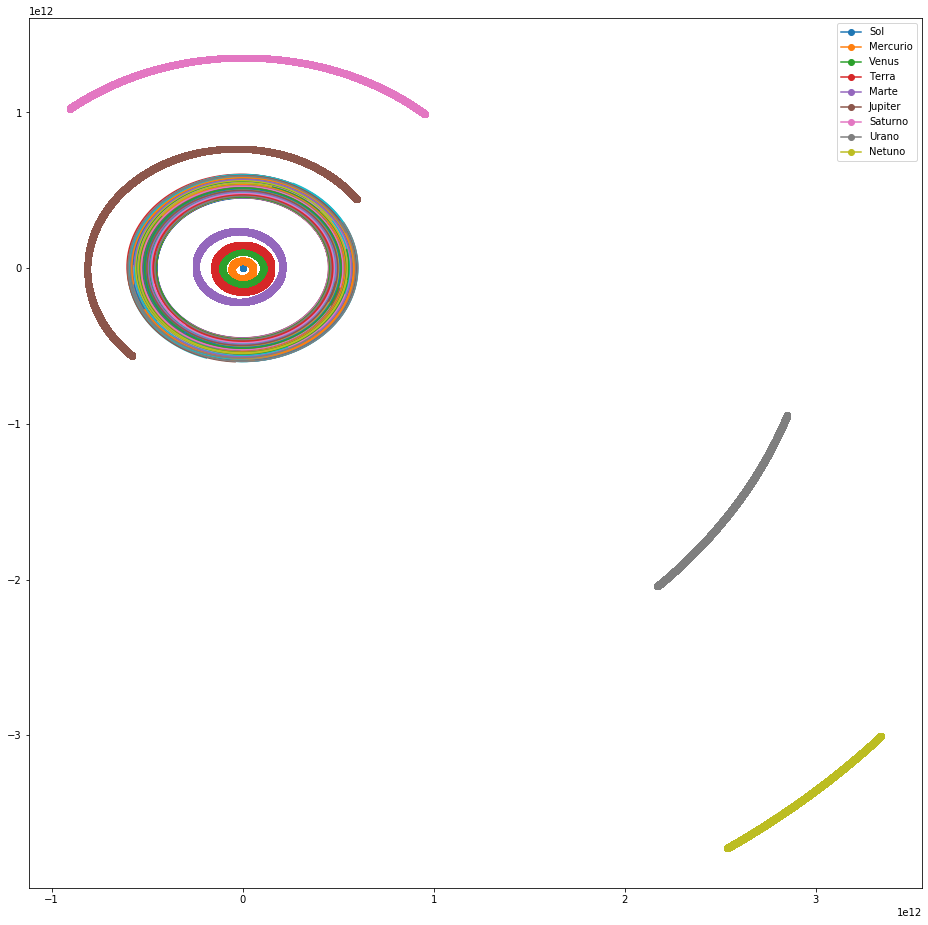

In [30]:
fig, ax = plt.subplots(1,1, figsize=(16, 16))
for i in range(NUM_OF_BODIES):
    if(i < NUM_KNOWN_BODIES):
        ax.plot(with_ast_positions[i][0], with_ast_positions[i][1], 'o-', label=body_names[i])
    else:
        ax.plot(with_ast_positions[i][0], with_ast_positions[i][1])
plt.legend()
plt.show()

In [31]:
NUM_STEPS = int(2e+4)
with_ast_frames = [None]*NUM_STEPS
for i in range(NUM_STEPS):
    x = np.zeros(NUM_OF_BODIES)
    y = np.zeros(NUM_OF_BODIES)
    z = np.zeros(NUM_OF_BODIES)
    for j in range(NUM_OF_BODIES):
        x[j] = with_ast_positions[j].iloc[i, 0]
        y[j] = with_ast_positions[j].iloc[i, 1]
        z[j] = with_ast_positions[j].iloc[i, 2]
    with_ast_frames[i] = [x, y, z]

In [32]:
axmax1 = max([max(np.absolute(with_ast_frames[i][0][0:6])) for i in range(NUM_STEPS)])
aymax1 = max([max(np.absolute(with_ast_frames[i][1][0:6])) for i in range(NUM_STEPS)])
azmax1 = max([max(np.absolute(with_ast_frames[i][2][0:6])) for i in range(NUM_STEPS)])
axmax2 = max([max(np.absolute(with_ast_frames[i][0])) for i in range(NUM_STEPS)])
aymax2 = max([max(np.absolute(with_ast_frames[i][1])) for i in range(NUM_STEPS)])
azmax2 = max([max(np.absolute(with_ast_frames[i][2])) for i in range(NUM_STEPS)])

In [37]:
plt.rcParams['animation.ffmpeg_path'] ='C:\\ffmpeg\\bin\\ffmpeg.exe'
def anima2(name, N_FRAMES, frames, xlim_, ylim_, xlim, ylim, names, title): 
    fig = plt.figure(figsize=(14, 4))
    ax1 = fig.add_subplot(1,2,1)
    ax2 = fig.add_subplot(1,2,2)
    ax1.set_xlim(-1*xlim_, xlim_)
    ax1.set_ylim(-1*ylim_, ylim_)
    ax2.set_xlim(-1*xlim, xlim)
    ax2.set_ylim(-1*ylim, ylim)
    def init():
        ax1.plot(frames[0][0], frames[0][1], 'o')
        ax2.plot(frames[0][0], frames[0][1], 'o')
        return ax1, ax2
    def iterate(i):
        ax1.clear()
        ax2.clear()
        ax1.set_xlim(-1*xlim_, xlim_)
        ax1.set_ylim(-1*ylim_, ylim_)
        ax2.set_xlim(-1*xlim, xlim)
        ax2.set_ylim(-1*ylim, ylim)
        ax1.plot(frames[i][0][1:NUM_KNOWN_BODIES+1], frames[i][1][1:NUM_KNOWN_BODIES+1], 'o')
        ax2.plot(frames[i][0][1:NUM_KNOWN_BODIES+1], frames[i][1][1:NUM_KNOWN_BODIES+1], 'o')
        ax1.plot(frames[i][0][NUM_KNOWN_BODIES:], frames[i][1][NUM_KNOWN_BODIES:], 'o', color='gray')
        ax2.plot(frames[i][0][NUM_KNOWN_BODIES:], frames[i][1][NUM_KNOWN_BODIES:], 'o', color='gray')
        ax1.plot(frames[i][0][0], frames[i][1][0], '*', markersize=13)
        ax2.plot(frames[i][0][0], frames[i][1][0], '*', markersize=13)
        for j in range(NUM_KNOWN_BODIES):
            ax1.annotate(names[j], (frames[i][0][j], frames[i][1][j]))
            ax2.annotate(names[j], (frames[i][0][j], frames[i][1][j]))
        return ax1, ax2
    ani = animation.FuncAnimation(fig, iterate, N_FRAMES, init_func=init, interval=10)
    FFwriter = animation.FFMpegWriter(fps=120, extra_args=['-vcodec', 'libx264'])
    ani.save(name+'.mp4', writer=FFwriter)

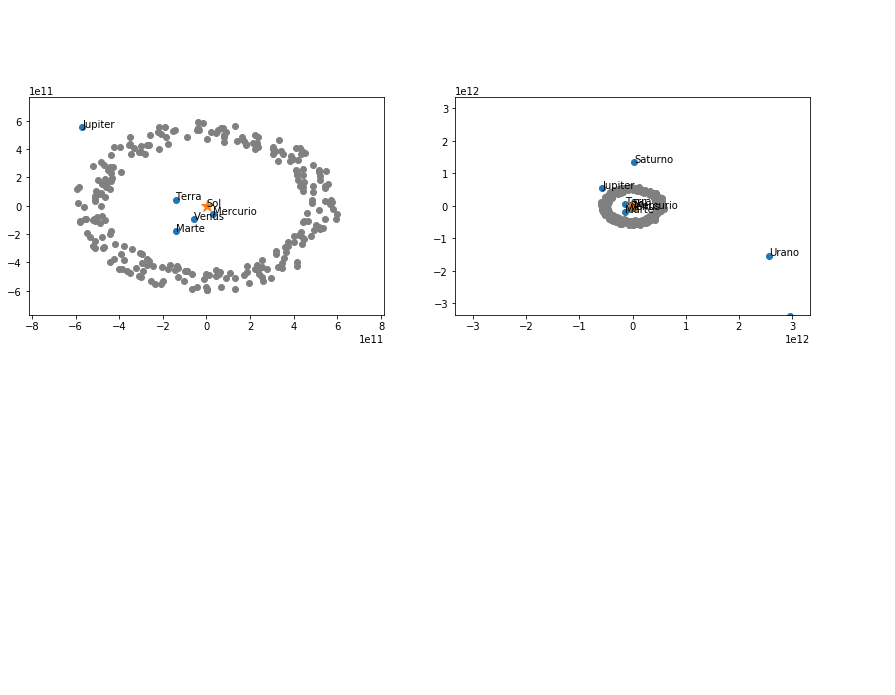

In [38]:
anima2('with_asteroids', 10000, with_ast_frames, axmax1, aymax1, axmax2, axmax2, body_names, 'Simulating the asteroid belt')

In [39]:
Video('with_asteroids.mp4')